In [1]:
from LMCneuron import LMCneuron
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance
import cv2

In [2]:
## testing neuron outputs
s = np.array([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])
neuron = LMCneuron(s, -0.03, 0.5)
out = neuron.neuron_out()
out

array([-0.03 ,  0.017,  0.037,  0.057,  0.077,  0.097,  0.117,  0.137])

## trajectory of images inputs and outputs

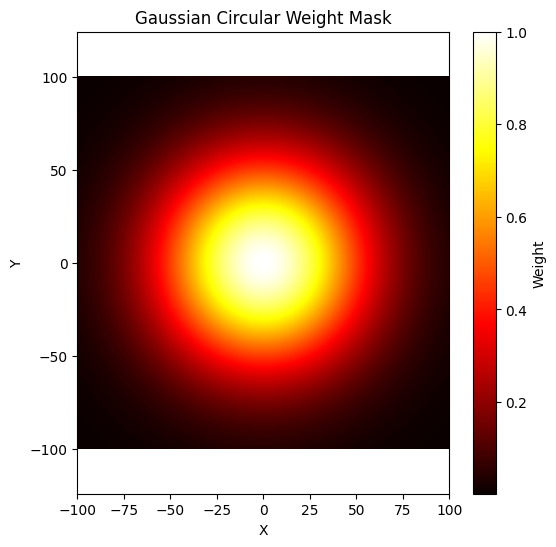

In [3]:
def gaussian_circular_weight_mask(size, sigma):
    x = np.linspace(-size // 2, size // 2, size)
    y = np.linspace(-size // 2, size // 2, size)
    xv, yv = np.meshgrid(x, y)
    distance_squared = xv**2 + yv**2
    # Apply the Gaussian function
    mask = np.exp(-distance_squared / (2 * sigma**2))
    # Normalize the weights
    #mask /= np.sum(mask)
    mask = mask/np.max(mask)
    return mask

# Parameters
size = 200  # Size of the square array
sigma = 40  # Standard deviation of the Gaussian distribution

# Generate the mask
gaussian_mask = gaussian_circular_weight_mask(size, sigma)
# Plot the mask
plt.figure(figsize=(6, 6))
plt.imshow(gaussian_mask, cmap='hot', extent=[-size // 2, size // 2, -size // 2, size // 2])
plt.colorbar(label='Weight')
plt.title('Gaussian Circular Weight Mask')
plt.xlabel('X')
plt.ylabel('Y')
plt.axis('equal')
plt.show()

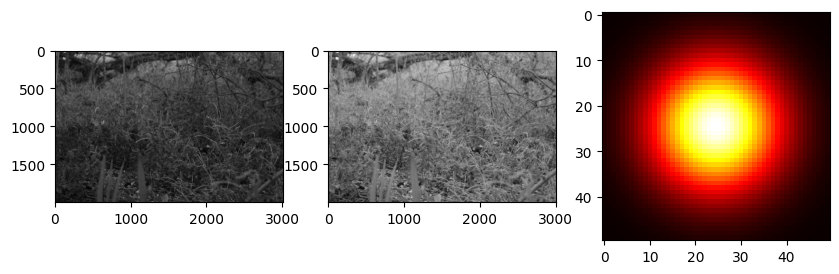

In [26]:
light = cv2.imread('DSC_1809.JPG',0)/255
dark = cv2.imread('DSC_1833.JPG',0)/255

# light = cv2.imread('light.jpeg',0)/255
# dark = cv2.imread('dark.jpeg',0)/255

plt.figure(figsize = (10,6))
plt.subplot(1,3,1)
plt.imshow(dark, cmap = 'gray')
plt.subplot(1,3,2)
plt.imshow(light, cmap = 'gray')
plt.subplot(1,3,3)
plt.imshow(gaussian_mask, cmap = 'hot')

In [27]:
# Random trajectory equation
def trajectory(z, omega, gamma): # omega is frequency, gamma is slope of linear component
    noise = np.random.normal(0, 0.1, len(z))  # Gaussian noise
    return 30 * np.sin(2 * np.pi * 3 * omega * z / 1000) + gamma * z + 60 * noise

In [28]:
def trajectory_outputs(image, mask, pool_norm = 'True', num_trajectories = 15):
    omega = 0.01  # Frequency factor for the sine component
    gamma = 2.5  # Slope for the linear component
    z_values = np.linspace(0, 10, 100)  # Z-axis values 

    image_width, image_height = image.shape[1], image.shape[0]
    mask_width, mask_height = mask.shape[0], mask.shape[1]
    # plt.figure()
    # plt.imshow(image, cmap='gray')
    # plt.axis("off")

    trajectories_output = []

    # plotting multiple trajectories
    for _ in range(num_trajectories):
        # Generate trajectory
        T_values = trajectory(z_values, omega, gamma)
        
        # Normalize trajectory to fit within the image dimensions
        z_scaled = np.interp(z_values, (z_values.min(), z_values.max()), (mask_width/2, image_width-mask_width/2))
        T_scaled = np.interp(T_values, (T_values.min(), T_values.max()), (mask_height/2, image_height-mask_height/2))
        
        # Overlay trajectory on the image
        input_val = []
        # plt.plot(z_scaled, T_scaled, linewidth=1)
        
        for i in range(len(z_scaled)):
            z = int(z_scaled[i])
            t = int(T_scaled[i])
            if pool_norm == 'True':
                temp_matrix = image[t-int(mask_height/2):t+int(mask_height/2),z-int(mask_width/2):z+int(mask_width/2)]*mask
                input = np.max(temp_matrix) # max pooling from gaussian
                input = input/np.mean(temp_matrix) # normalisation step
                input_val.append(input)
            else:
                input_val.append(image[t,z])
        
        input_val = np.array(input_val)
        neuron = LMCneuron(input_val, -0.03, 0.5)
        out = neuron.neuron_out()
        trajectories_output.append(out)
    neuron_out = np.array(trajectories_output)
    neuron_out = neuron_out.flatten()
    return neuron_out

In [29]:
scales = np.arange(2,50,2)
losses = []
dark_variance = []
light_variance = []
for scale in scales:
    mask = gaussian_circular_weight_mask(size = int(scale), sigma = scale/5)
    neuron_out_dark = trajectory_outputs(dark, mask, pool_norm = 'True', num_trajectories = 15)
    neuron_out_light = trajectory_outputs(light, mask, pool_norm = 'True', num_trajectories = 15)
    neuron_out_light_nonpool = trajectory_outputs(light, mask, pool_norm = 'False', num_trajectories = 15)
    neuron_out_dark_nonpool = trajectory_outputs(dark, mask, pool_norm = 'False', num_trajectories = 15)

    #loss = loss_function(neuron_out_dark, neuron_out_light, neuron_out_light_nonpool)
    #losses.append(loss)
    loss1 = wasserstein_distance(neuron_out_dark, neuron_out_light)
    var_light = np.var(neuron_out_light)
    light_variance.append(var_light)
    var_dark = np.var(neuron_out_dark)
    dark_variance.append(var_dark)

    loss = (0.1*(loss1)/np.sqrt(var_light*var_dark))

    losses.append(loss)
    
    print('mask size: ', scale, 'Loss : ', np.round(loss,4), 'light var = ', np.round(var_light,4), 'dark_var = ', np.round(var_dark,4))

mask size:  2 Loss :  0.4137 light var =  0.0006 dark_var =  0.0007
mask size:  4 Loss :  0.0772 light var =  0.0069 dark_var =  0.0075
mask size:  6 Loss :  0.0945 light var =  0.0106 dark_var =  0.0116
mask size:  8 Loss :  0.0556 light var =  0.0122 dark_var =  0.013
mask size:  10 Loss :  0.0547 light var =  0.0133 dark_var =  0.0145
mask size:  12 Loss :  0.0677 light var =  0.014 dark_var =  0.0159
mask size:  14 Loss :  0.0934 light var =  0.015 dark_var =  0.0189
mask size:  16 Loss :  0.0823 light var =  0.0163 dark_var =  0.0204
mask size:  18 Loss :  0.0949 light var =  0.0174 dark_var =  0.0226
mask size:  20 Loss :  0.078 light var =  0.0199 dark_var =  0.0247
mask size:  22 Loss :  0.0802 light var =  0.0204 dark_var =  0.0282
mask size:  24 Loss :  0.1111 light var =  0.0212 dark_var =  0.0321
mask size:  26 Loss :  0.1153 light var =  0.0246 dark_var =  0.0366
mask size:  28 Loss :  0.1176 light var =  0.0251 dark_var =  0.0418
mask size:  30 Loss :  0.0685 light var = 

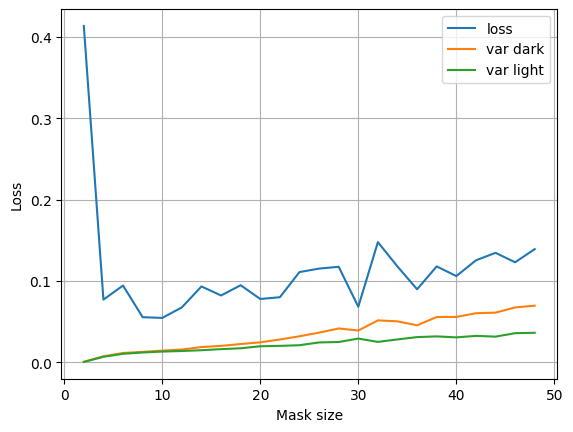

In [32]:
plt.plot(scales, losses, label = 'loss')
plt.plot(scales, dark_variance, label = 'var dark')
plt.plot(scales, light_variance, label = 'var light')
plt.xlabel('Mask size')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.savefig("Loss.png", dpi=300, bbox_inches="tight")

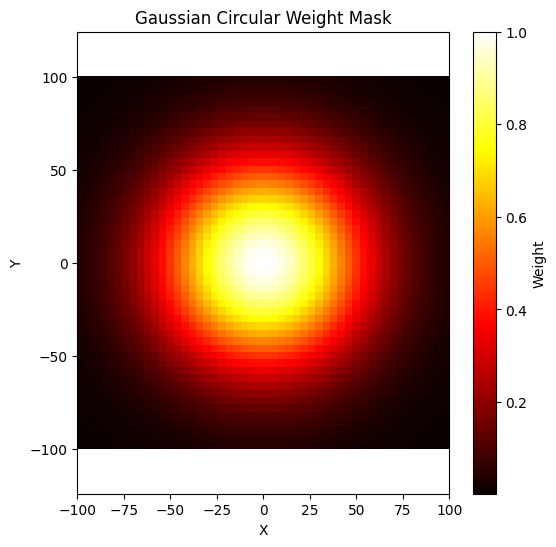

In [22]:
# Generate the mask
gaussian_mask = gaussian_circular_weight_mask(50, 50/5)
# Plot the mask
plt.figure(figsize=(6, 6))
plt.imshow(gaussian_mask, cmap='hot', extent=[-size // 2, size // 2, -size // 2, size // 2])
plt.colorbar(label='Weight')
plt.title('Gaussian Circular Weight Mask')
plt.xlabel('X')
plt.ylabel('Y')
plt.axis('equal')
plt.show()

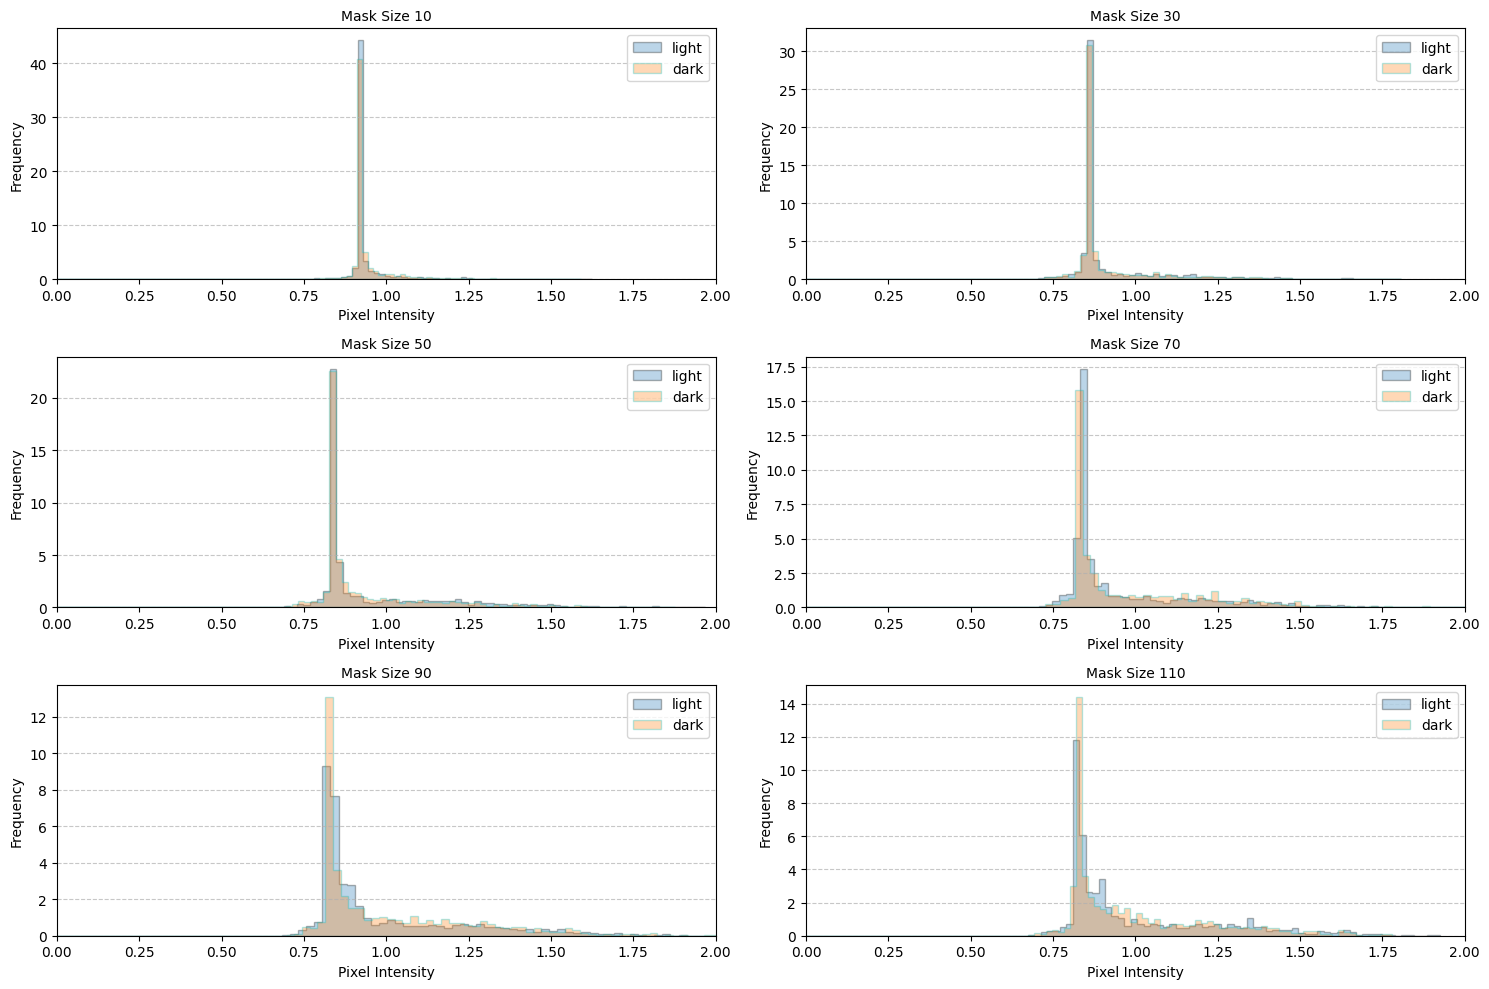

In [23]:
scales = np.arange(10,120,20)
losses = []
dark_variance = []
light_variance = []
plt.figure(figsize = (15,10))
num = 1
for scale in scales:
    mask = gaussian_circular_weight_mask(size = int(scale), sigma = scale/5)
    neuron_out_dark = trajectory_outputs(dark, mask, pool_norm = 'True', num_trajectories = 15)
    neuron_out_light = trajectory_outputs(light, mask, pool_norm = 'True', num_trajectories = 15)
    
    plt.subplot(3,2,num)
    num+=1
    plt.hist(neuron_out_light, density=True, histtype='stepfilled', alpha=0.3, bins=100, ec="k", lw=1, label = 'light')
    plt.hist(neuron_out_dark, density=True, histtype='stepfilled', alpha=0.3, bins=100, ec="c", lw=1, label = 'dark')
    # Add labels and title
    plt.title("Mask Size {}".format(scale), fontsize=10)
    plt.xlabel("Pixel Intensity", fontsize=10)
    plt.ylabel("Frequency", fontsize=10)
    plt.xlim(0, 2)
    plt.legend()
    # Grid and aesthetics
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
plt.savefig("hist_pool.png", dpi=500, bbox_inches="tight")

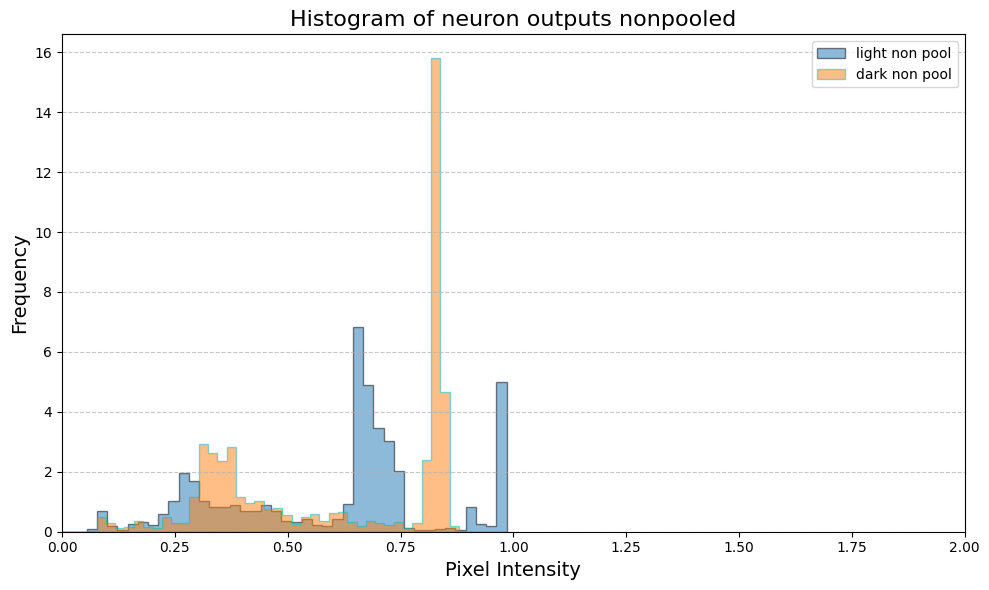

In [25]:
# Plot histogram
neuron_out_light_nonpool = trajectory_outputs(light, mask, pool_norm = 'False', num_trajectories = 15)*5
neuron_out_dark_nonpool = trajectory_outputs(dark, mask, pool_norm = 'False', num_trajectories = 15)*5

plt.figure(figsize=(10, 6))
plt.hist(neuron_out_light_nonpool, density=True, histtype='stepfilled', alpha=0.5, bins=50, ec="k", lw=1, label = 'light non pool')
plt.hist(neuron_out_dark_nonpool, density=True, histtype='stepfilled', alpha=0.5, bins=50, ec="c", lw=1, label = 'dark non pool')

# Add labels and title
plt.title("Histogram of neuron outputs nonpooled", fontsize=16)
plt.xlabel("Pixel Intensity", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xlim(0, 2)
plt.legend()
# Grid and aesthetics
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("hist_nonpool.png", dpi=300, bbox_inches="tight")

### Show contrast eq

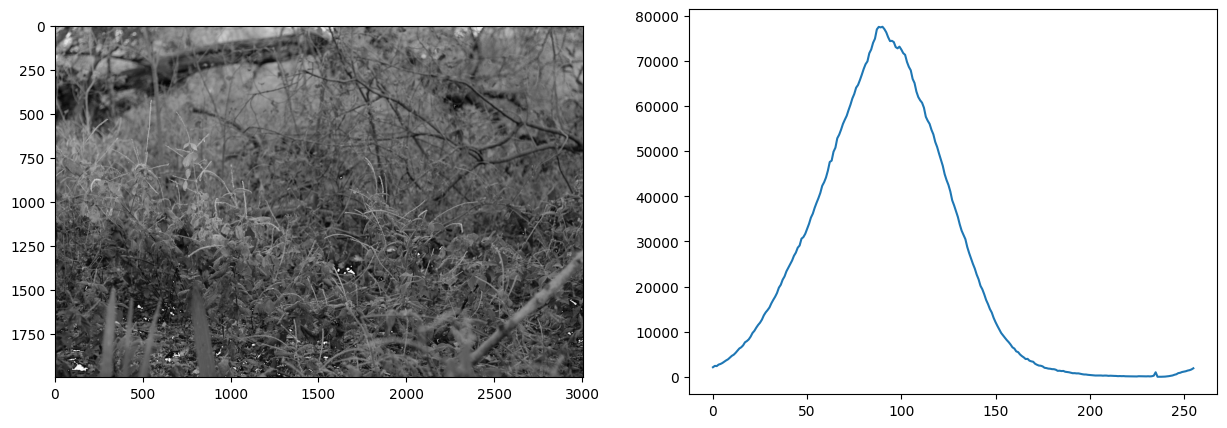

In [13]:
img = np.array(cv2.imread('DSC_1803.jpg',0), dtype = 'uint8')
img = img-20

hist = cv2.calcHist([img],[0],None,[256],[0,256])
# show the plotting graph of an image
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.imshow(img, cmap = 'gray')
plt.subplot(1,2,2)
plt.plot(hist)
plt.savefig("dark_hist.png", dpi=500, bbox_inches="tight")

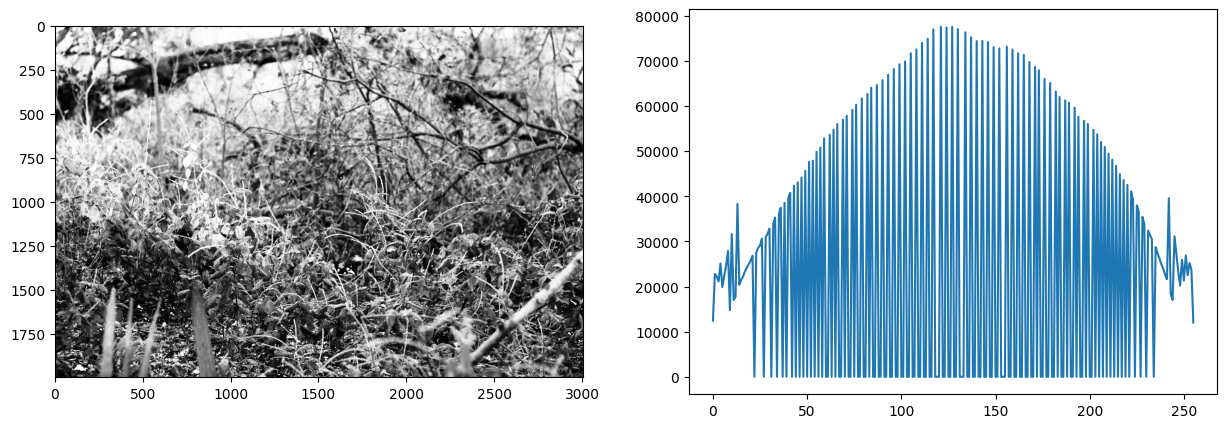

In [14]:
hist_eq = cv2.equalizeHist(img)
hist = cv2.calcHist([hist_eq],[0],None,[256],[0,256])
# show the plotting graph of an image
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.imshow(hist_eq, cmap = 'gray')
plt.subplot(1,2,2)
plt.plot(hist)
plt.savefig("light_hist.png", dpi=500, bbox_inches="tight")